# Tarea 13. MCMC 

In [1]:
import numpy as np
import sympy as sy
import scipy as sp
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.integrate import quad
import scipy.stats as st

sy.init_printing()    #para que imprima bonito las integrales

from matplotlib import animation, rc
#from IPython.display import HTML
#%matplotlib inline
#sb.set()


#tex PREAMBLE

#******************************************************

#rc('font',**{'family':'serif','serif':['Times']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

#LaTeX
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

### Instrucciones: obtener contornos de confianza para los parámetros $w_0$ y $w_a$, usando una parametrización CPL y los conjuntos de datos:

- Cosmic Clocks
- SN1a

## I. Datos

#### A) SN1a:

- Dataset: Pantheon binned. 
- Tomados de: <a href="https://github.com/ja-vazquez/SimpleMC/tree/master/simplemc/data"> GitHub JAVazquez</a>

In [2]:
#para ver en que consiste el archivo
#%cat binned_pantheon_15.txt

In [3]:
data_pantheon15 = np.loadtxt('binned_pantheon_15.txt',dtype=float, skiprows=0)
df_pthn= pd.DataFrame(data_pantheon15, columns=['z','mu'])
df_pthn.head()

#me resultó mejor usar np.loadtxt y luego convertir a dataframe pues pd.readcsv no detecta los espacios como 
#separados

,z,mu
0,0.014353,14.67655
1,0.020602,15.43421
2,0.029571,16.30360
3,0.042444,17.05419
4,0.060921,17.86946


La matriz de covarianza de binned_pantheon_15 ya está dada:

In [4]:
cov_pantheon15 = np.loadtxt('binned_cov_pantheon_15.txt',dtype=float, skiprows=0)
cov_pthn= pd.DataFrame(cov_pantheon15)
cov_pthn.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.012424,0.008673,0.010044,0.009380,0.010702,0.009104,0.009102,0.009157,0.009276,0.009273,0.009183,0.009059,0.010522,0.007242,0.006324
1,0.008673,0.009761,0.008258,0.008069,0.009244,0.007989,0.007970,0.008092,0.008010,0.008127,0.007999,0.007953,0.008839,0.007086,0.009422
2,0.010044,0.008258,0.009822,0.008438,0.009841,0.008733,0.008656,0.008700,0.008744,0.008778,0.008773,0.008704,0.009698,0.006974,0.009656
3,0.009380,0.008069,0.008438,0.008808,0.009127,0.008262,0.008175,0.008211,0.008243,0.008233,0.008196,0.008226,0.008945,0.006326,0.006706
4,0.010702,0.009244,0.009841,0.009127,0.011322,0.009294,0.009240,0.009365,0.009357,0.009342,0.009321,0.009239,0.010264,0.007568,0.009283


#### B) Cosmic Clocks:

- Dataset: Cosmic Clocks 2018. 
- Tomados de: <a href="https://arxiv.org/abs/1706.09848">arXiv:1706.09848</a>


In [5]:
data_cc2022 = np.loadtxt('cosmic_clocks_2022_nomethod.csv',delimiter=',',dtype=float, skiprows=1)
df_cc= pd.DataFrame(data_cc2022, columns=['z','Hz','error_Hz'])
df_cc.head()

,z,Hz,error_Hz
0,0.0700,69.0,19.6
1,0.1000,69.0,12.0
2,0.1200,68.6,26.2
3,0.1700,83.0,8.0
4,0.1791,75.0,4.0


Construimos la matriz de covarianza a partir de los errores:

In [6]:
err= df_cc['error_Hz']**2
cov_cc = pd.DataFrame(np.diag(err),index=err.index,columns=err.index)
#covcc

## II. Modelo

Necesitamos:
1. Ecuación de Friedmann
2. Definir una distancia (distancia luminosa $d_L$)
3. Modelo para $H_0$ y $\mu$, que son nuestras observables. Para el primero usaremos la ecuación de Friedmann, para el segundo, el módulo de la distancia.

Sabemos que la distancia lumínica está dada por:

$$dL(z)=\frac{c}{H_0} (1+z) \int_0^z \frac{dz^*}{E(z^*)}$$ (en el caso donde $\Omega_k^0=0$)

y 

$$dL(z)=\frac{c}{H_0} \frac{(1+z)}{\sqrt{\Omega_k^0}} \sinh\left( \sqrt{\Omega_k^0} \int_0^z \frac{dz^*}{E(z^*)}\right)$$ (en el caso donde $\Omega_k\neq0$) (Amendola, Tsujikawa. p.21)

#### Usemos la primera expresión

In [20]:
# 1. Ecuación de Friedmann (normalizada) para w(z) de CPL (visto en tarea 9)

def Hz_CPL(z,w0,OmM):
    
    # Usando datos de Planck 2018: 
    # Tabla 2: TT,TE,EE+lowE+lensing+BAO
    # Tabla 6 para valor de wa

    #OmDE = 0.6889
    wa = -0.28
    #OmM = 0.3111
    H0 = 67.66  
    
    Hz = H0*np.sqrt(OmM*(1+z)**3 + (1-OmM)*(1+z)**(3*(w0+wa+1)*np.exp(-3*wa*z/1+z)))
    return Hz

# 2. Distancia luminosa

def Ez(z,w0,OmM):
    
    # Usando datos de Planck 2018: 
    # Tabla 2: TT,TE,EE+lowE+lensing+BAO
    # Tabla 6 para valor de wa

    #OmDE = 0.6889
    wa = -0.28
    #OmM = 0.3111
    H0 = 67.66  
    
    Ez = Hz_CPL(z,w0,OmM)/H0
    return Ez

def Ezinv(z,w0,OmM):
    
    # Usando datos de Planck 2018: 
    # Tabla 2: TT,TE,EE+lowE+lensing+BAO
    # Tabla 6 para valor de wa

    #OmDE = 0.6889
    wa = -0.28
    #OmM = 0.3111
    H0 = 67.66  
    
    Ezinv = 1/Ez(z,w0,OmM)
    return Ezinv

def xi(z,w0,OmM):
    
    # Usando datos de Planck 2018: 
    # Tabla 2: TT,TE,EE+lowE+lensing+BAO
    # Tabla 6 para valor de wa

    #OmDE = 0.6889
    wa = -0.28
    #OmM = 0.3111
    H0 = 67.66  
    
    xi = np.array([quad(Ezinv, 0.001, i, args=(w0,OmM))[0] for i in z])
    return xi

def mu(z,w0,OmM):
    c=300000
    H0 = 67.66
    #dL1=(1+z)*(c/H0)*xi
    #dL2=(1+z)*xi(z,w0,wa)
    #mu=(5*np.log10(dL2))-5
    mu=5*np.log10((c/H0)*xi(z,w0,OmM)*(1+z))-5
    return mu

In [21]:
#test if Ezinv() works
#Ezinv(1,-1,0)

#---------------

#test if xi() works
#zrange=np.linspace(0.001,2.5,20)
#5*np.log10((300000/H0)*xi(zrange,-0.9,-0.1)*(1+zrange))-5

#---------------

#test if mu() works
zrange=np.linspace(0.01,2.5,20)
mu(zrange,-1,0.5)

array([ 3.0202974 ,  9.16562189, 10.75187148, 11.73383541, 12.45063467,
       13.01460798, 13.47805213, 13.87019098, 14.20933461, 14.50779749,
       14.7742084 , 15.01477401, 15.2340663 , 15.43553831, 15.62186092,
       15.79514346, 15.95708147, 16.10905885, 16.2522201 , 16.38752272])

## III. MCMC

### A) Definimos likelihoods (CC y SN1a)

Como vimos en la tarea 11, la $\chi^2$ se define, mediante la matriz de covarianza $C$ como: 

### $$\chi^2=(m-d)^T C^{-1} (m-d)$$

Donde $m$ son los valores teóricos de la observable ($i.e.$ $H_0$, $\mu$, etc) y $d$ los datos.

Además, si tenemos varios datasets por ejemplo SN1a y H(z) el likelihood total se obtiene de la siguiente manera:

$$\mathcal{L} = \mathcal{L}_{\text{SN1a}}+\mathcal{L}_{\text{H(z)}} = \text{exp}\left[-(\chi^2_{\text{SN1a}}+\chi^2_{\text{H(z)}})/2\right]$$

In [22]:
def loglikecc(params):
    w0    = params[0]
    OmM    = params[1]
    delta = Hz_CPL(df_cc['z'],w0,OmM) - df_cc['Hz']
    chisquare = np.dot(np.transpose(delta), np.dot(np.linalg.inv(cov_cc), delta))
    return -chisquare/2

def loglikesn1a(params):
    w0    = params[0]
    OmM    = params[1]
    delta = mu(df_pthn['z'],w0,OmM) - df_pthn['mu']
    chisquare = np.dot(np.transpose(delta), np.dot(np.linalg.inv(cov_pantheon15), delta))
    return -chisquare/2

def loglikeTOT(params):
    w0    = params[0]
    OmM    = params[1]
    
    deltacc = Hz_CPL(df_cc['z'],w0,OmM) - df_cc['Hz']
    chisquarecc = np.dot(np.transpose(deltacc), np.dot(np.linalg.inv(cov_cc), deltacc))

    deltasn1a = mu(df_pthn['z'],w0,OmM) - df_pthn['mu']
    chisquaresn1a = np.dot(np.transpose(deltasn1a), np.dot(np.linalg.inv(cov_pantheon15), deltasn1a))
    
    return np.exp(-(chisquarecc+chisquaresn1a)/2)


### A partir de aquí, utilicé el código desarrollado por Alberto y modificado a este ejercicio.

Función objetivo

In [23]:
#se define funcion objetivo
def target(lik, prior, theta):
    #prior by hand
    #if theta[0] < 90 or theta[0] >120:
    #    return -1.0E50
    #else:
    return lik(theta)
    #return lik(param[0], theta).pmf(param[1])*prior.pdf(theta)

Metropolis Hastings algorithm

In [24]:
def metropolissampler(niters, lik, prior, theta,  sigma):
    accepted = 0
    samples  = [] 
    likeli   = []
    
    samples.append(theta)
    likeli.append(target(lik, prior, theta))
    
    for i in range(niters):
        theta_p = theta + sigma* np.random.normal(0.,1., len(theta)) 
        likeratio=np.exp(target(lik, prior, theta_p) - \
                            target(lik, prior, theta))        
        rho = np.minimum(1, likeratio)
        
        
        if rho > np.random.uniform():
            theta = theta_p
            accepted += 1
            
        #cuando GR = 1 stop:
            
        samples.append(theta)
        likeli.append(target(lik, prior, theta))
    print ('Aceptance rate', 1.0*accepted/niters)
    return samples


## I. Revisando convergencia con $\mathcal{L}_{Tot}$:

/home/hikuri/software/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_151360/3889207118.py:14: RuntimeWarning: invalid value encountered in sqrt
  Hz = H0*np.sqrt(OmM*(1+z)**3 + (1-OmM)*(1+z)**(3*(w0+wa+1)*np.exp(-3*wa*z/1+z)))
/tmp/ipykernel_151360/3889207118.py:58: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  xi = np.array([quad(Ezinv, 0.001, i, args=(w0,OmM))[0] for i in z])


Aceptance rate 0.976
Aceptance rate 0.9785
Aceptance rate 0.979


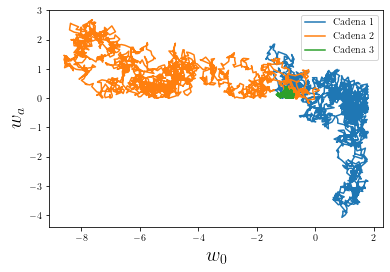

In [31]:
lik    = loglikeTOT
sigma  = [[0.1, 0.1] , [0.1,0.1], [0.01, 0.01]]
theta  = [[-0.99, 0.9], [-0.01, 0.23], [-0.9, 0.1]] 
#sigma  = [[-1., 1.]]
#theta  = [[-10., -5]] 
niters = 2000
#prior  = st.uniform(1)
prior = [-1,0]

nchains = 3
cadenas = []

#for i in range(nchains):
#    tmp= metropolissampler(niters, lik, prior, theta[i], w0[i])
#    df = pd.DataFrame(tmp)
#    df.to_csv('cadenas_{}.txt'.format(i+1), header=None, index=None, sep='\t')

for i in range(nchains):
    cadenas.append(metropolissampler(niters, lik, prior, theta[i], sigma[i]))
    plt.plot(list(zip(*cadenas[i]))[0], list(zip(*cadenas[i]))[1], label = "Cadena "+str(i+1))
    
    
plt.ylabel('$w_a$',fontsize=20)
plt.xlabel('$w_0$',  fontsize=20)
plt.legend()
plt.show()

In [32]:
cadenas

[[[-0.99, 0.9],
  array([-0.83456008,  1.02021015]),
  array([-0.93733801,  0.98179047]),
  array([-0.93026898,  1.01113926]),
  array([-0.89677226,  0.99286452]),
  array([-0.89001351,  1.1317615 ]),
  array([-0.84568238,  1.0965672 ]),
  array([-0.95825856,  1.18162942]),
  array([-1.06623677,  1.07014459]),
  array([-1.01273349,  1.11032096]),
  array([-0.97168866,  1.23755031]),
  array([-1.03062535,  1.17549391]),
  array([-0.97519389,  1.07874321]),
  array([-0.98031908,  1.21284409]),
  array([-0.98031908,  1.21284409]),
  array([-1.04082263,  1.25478771]),
  array([-1.06543407,  1.2581077 ]),
  array([-1.05445022,  1.43267301]),
  array([-1.0242327 ,  1.42434386]),
  array([-0.93212003,  1.35637027]),
  array([-1.04276671,  1.30291132]),
  array([-1.04474338,  1.24556112]),
  array([-1.11265129,  1.24732587]),
  array([-1.05355639,  1.19229927]),
  array([-1.34741349,  1.15796241]),
  array([-1.39351318,  1.17939081]),
  array([-1.40134175,  1.2102416 ]),
  array([-1.42137857, 

Notamos que, usando pasos más pequeños (cadena 3) se obtienen resultados buenos! En este caso, el último paso de la cadena 3 obtuvo los siguientes resultados:

### $$(w_0,\Omega_m) = \{-1.0044,0.2693\}$$

Sin embargo, la convergencia no fue suficiente para las otras dos cadenas